In [14]:
import rdkit
from rdkit import Chem
import pandas as pd
import json
import ast
import matplotlib.pyplot as plt
import sklearn
import numpy as np

import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import least_squares


In [2]:
df = pd.read_excel('intensity_data.xlsx', header=1)  # 데이터가 두 번째 행부터 시작하므로 header=1로 설정

# 컬럼의 짝수 열과 홀수 열로 나누기
shift_columns = df.columns[::2]  # 짝수 열 (Raman shift)
intensity_columns = df.columns[1::2]  # 홀수 열 (Intensity)

# Raman shift와 Intensity 데이터를 각각 저장
raman_shift_data = df[shift_columns]
intensity_data = df[intensity_columns]

# # 결과 확인
# print("Raman shift 데이터:")
# print(raman_shift_data.head())

# print("\nIntensity 데이터:")
# print(intensity_data.head())

In [3]:
# Raman shift 데이터를 전치한 후 리스트의 리스트로 변환
import math

# NaN 값을 제외하고 리스트의 리스트로 변환
raman_shift_list = raman_shift_data.T.values.tolist()
raman_shift_list = [[value for value in row if not (isinstance(value, float) and math.isnan(value))] for row in raman_shift_list]

intensity_list = intensity_data.T.values.tolist()
intensity_list = [[value for value in row if not (isinstance(value, float) and math.isnan(value))] for row in intensity_list]




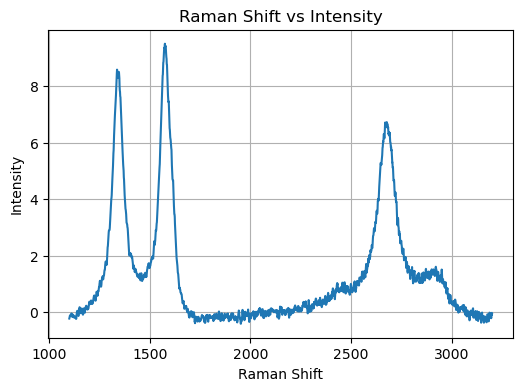

In [4]:
idx = 7
plt.figure(figsize=(6, 4))
plt.plot(raman_shift_list[idx], intensity_list[idx], linestyle='-')
plt.xlabel("Raman Shift")
plt.ylabel("Intensity")
plt.title("Raman Shift vs Intensity")
plt.grid(True)
plt.show()

Check the dark current

In [5]:
data = {
    'Raman Shift': raman_shift_list[idx],
    'Intensity':  intensity_list[idx]
}
df = pd.DataFrame(data)


# 사용자가 평균을 계산할 데이터 포인트 개수를 설정
num_points = int(input("평균을 계산할 데이터 포인트 개수를 입력하세요: "))

# 평균 및 표준 편차 계산을 위한 리스트 초기화
average_intensity = []
std_dev_intensity = []

# 이동 평균과 표준 편차 계산
for i in range(len(df) - num_points + 1):
    segment = df['Intensity'].iloc[i:i + num_points]
    avg = segment.mean()
    std_dev = segment.std()
    average_intensity.append(avg)
    std_dev_intensity.append(std_dev)

# 표준 편차가 가장 낮은 구간을 dark current로 선택
min_std_index = np.argmin(std_dev_intensity)
dark_current_segment = df.iloc[min_std_index:min_std_index + num_points]

# print("Dark current에 해당하는 구간:")
# print(dark_current_segment)

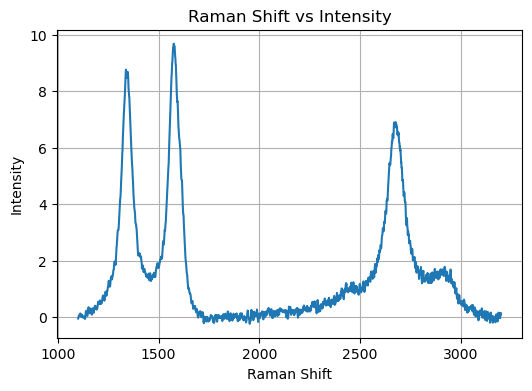

In [6]:
# dark_current_segment의 Intensity 평균 계산
dark_current_avg = dark_current_segment['Intensity'].mean()
dark_current_std = dark_current_segment['Intensity'].std()

# Raman shift 리스트에서 dark current 평균을 빼기
corrected_raman_shift_list = [value - dark_current_avg for value in df['Intensity']]


plt.figure(figsize=(6, 4))
plt.plot(raman_shift_list[idx], corrected_raman_shift_list, linestyle='-')
# plt.plot(raman_shift_list[i], intensity_list[i], linestyle='-', color='r')
plt.xlabel("Raman Shift")
plt.ylabel("Intensity")
plt.title("Raman Shift vs Intensity")
plt.grid(True)
plt.show()

In [25]:
intensity = corrected_raman_shift_list
raman_shift = raman_shift_list[idx]
print(len(raman_shift), len(intensity))
peaks, _ = find_peaks(intensity, height=dark_current_std*7, prominence=dark_current_std*5)  # height 파라미터로 최소 피크 높이를 설정하여 노이즈 제거
peaks


2255 2255


array([ 309,  344,  471,  485,  632,  870, 1067, 1083, 1804, 2033])

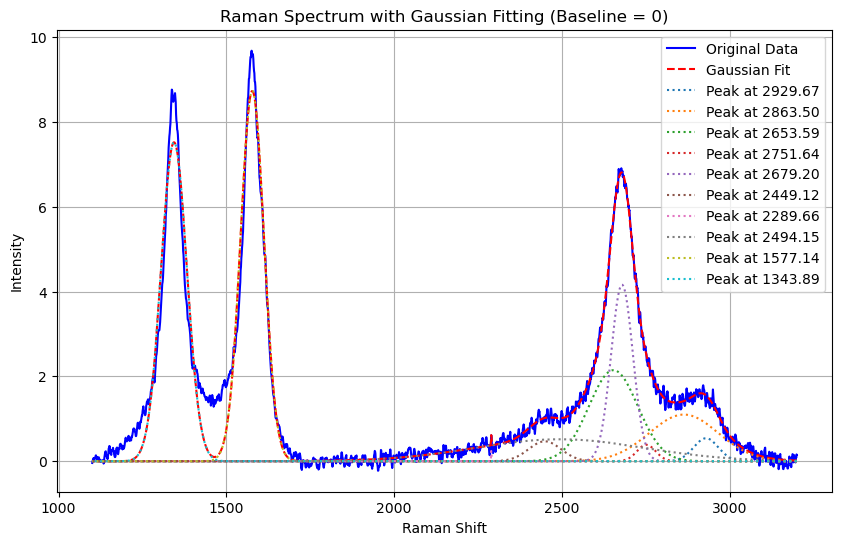

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# 가우시안 함수 정의
def gaussian(x, amp, cen, wid):
    return amp * np.exp(-(x - cen) ** 2 / (2 * wid ** 2))

# 다중 가우시안 함수 정의 (상수 오프셋 없이 baseline을 0으로 고정)
def multi_gaussian(x, params):
    y = np.zeros_like(x)  # baseline을 0으로 설정
    for i in range(0, len(params), 3):
        amp = params[i]
        cen = params[i + 1]
        wid = params[i + 2]
        y += gaussian(x, amp, cen, wid)
    return y

# 목적 함수 정의 (잔차를 최소화)
def residuals(params, x, y):
    return y - multi_gaussian(x, params)

# 초기값 설정
initial_guesses = []
for peak in peaks:
    amp = intensity[peak]
    cen = raman_shift[peak]
    wid = 1  # 임의의 초기값
    initial_guesses += [amp, cen, wid]

# 하한과 상한 설정 (암플리튜드는 0보다 크도록 설정)
signal_max = np.max(intensity)   # 신호의 최대값
raman_shift_max = np.max(raman_shift)+500  # Raman shift의 최대값
raman_shift_min = np.min(raman_shift)-500  # Raman shift의 최소값

# 하한과 상한 설정
lower_bounds = [0 if i % 3 == 0 else raman_shift_min if i % 3 == 1 else 0 for i in range(len(initial_guesses))]
upper_bounds = [signal_max if i % 3 == 0 else raman_shift_max if i % 3 == 1 else 1000 for i in range(len(initial_guesses))]

# Curve fitting 수행
result = least_squares(residuals, initial_guesses, bounds=(lower_bounds, upper_bounds), args=(raman_shift, intensity))
popt = result.x

# 피팅 결과 시각화
plt.figure(figsize=(10, 6))     
plt.plot(raman_shift, intensity, label="Original Data", color="blue")
plt.plot(raman_shift, multi_gaussian(raman_shift, popt), label="Gaussian Fit", color="red", linestyle="--")

# 개별 가우시안 함수 표시
for i in range(0, len(popt), 3):
    amp, cen, wid = popt[i:i+3]
    plt.plot(raman_shift, gaussian(raman_shift, amp, cen, wid), linestyle=":", label=f"Peak at {cen:.2f}")

plt.xlabel("Raman Shift")
plt.ylabel("Intensity")
plt.legend()
plt.title("Raman Spectrum with Gaussian Fitting (Baseline = 0)")
plt.grid()
plt.show()
